# MICROPROBING 

Before running this notebook - install this package
(i.e., in the terminal, inside this folder run:
"pip install -e .")

You also need: 

* emcee               https://emcee.readthedocs.io/en/stable/user/install/

* prfpy               https://github.com/VU-Cog-Sci/prfpy.git (or https://github.com/spinoza-centre/prfpy_csenf.git if you want the contrast sensitivity function.)

* dag_prf_utils       https://github.com/mdaghlian/dag_prf_utils.git


Also a bit of an apology... There is some inconsistency in naming between prfpy and dag_prf_utils. I promise there is a good reason for this. I want prfpy to be backwards compatible. But, some names interfere with each other, when you start including other models (e.g., size, compared to size_1, and size_2 in the DN model). Here is the mapping for the gaussian model:

```
prfpy       dag_prf_utils

mu_x        x
mu_y        y
size        size_1
beta        amp_1
baseline    bold_baseline
hrf_1       hrf_deriv
hrf_2       hrf_disp


```

Most of the time you shouldn't have to think about it...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


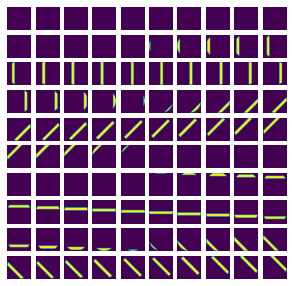

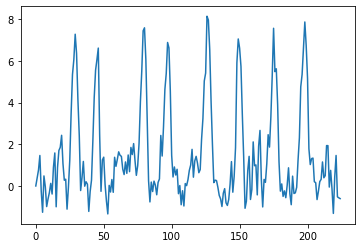

In [229]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
try:
    from prfpy.stimulus import PRFStimulus2D
    from prfpy.model import Iso2DGaussianModel
except:
    from prfpy_csenf.stimulus import PRFStimulus2D
    from prfpy_csenf.model import Iso2DGaussianModel
import os
import yaml
import pickle
from datetime import datetime

# If you already have the design matrix as a numpy array, you can simply load it...
dm = np.load('./design_matrix.npy')

# You can see we have a binarized matrix, of a bar moving across the screen...
fig = plt.figure()
rows = 10
cols = 10
fig.set_size_inches(5,5)
for i in range(100):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(dm[:,:,i], vmin=0, vmax=1)
    ax.axis('off')
# Now we need to enter the design matrix in a way that prfpy can read it. 
# If for some reason you do not have the original dimensions, but you do have the dov, you can use this calculator:
# https://elvers.us/perception/visualAngle/ to make up some values for screen_size and distance, which will work...
prf_stim = PRFStimulus2D(
    screen_size_cm=39.3,          # Distance of screen to eye
    screen_distance_cm=196,  # height of the screen (i.e., the diameter of the stimulated region)
    design_matrix=dm,                                   # dm (npix x npix x time_points)
    TR=1.5,                                  # TR
    )
# Now we can make the model
model = 'gauss'
# HRF is determined by coefficients for the canonical HRF, its time derivative, and its dispersion derivative
# Here we set it at 1, 4.6 and 0 (what we have found to work at spinoza)
prfpy_model = Iso2DGaussianModel(stimulus=prf_stim, hrf=[1, 4.6, 0]) 


# Load the runs

psc_runs = np.load('eg_data.npy')
# Show an example
plt.figure()
plt.plot(psc_runs[0,:])

# Metropolis Hastings - with MCMC 

Suggest using this rather than stretch move 

Also note that offset and amplitude occur outside the glm


In [230]:
from prfpy_bayes.micro_probe import MicroProbe
bprf = MicroProbe(
    prfpy_model = prfpy_model,  # prfpy model objects
    real_ts = psc_runs,         # time series (data)
    bounds = [-5,5],            # bounds for x,y
    tiny_prf_size = 0.01,       # tiny prf size     
)

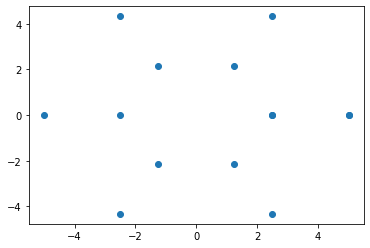

In [ ]:
# Some starting poisitions... (a bit random - but lets go for it for now)
pol = np.linspace(0, 2*np.pi, 7)
ecc = np.array([2.5, 5]) # , 2,3, 4,])
pol,ecc = np.meshgrid(pol, ecc)
x,y = ecc*np.cos(pol), ecc*np.sin(pol)
x,y = x.flatten(), y.flatten()
plt.scatter(x,y)
walkers = np.array([x,y]).T


In [232]:
# Lets run the fitting for voxel 0
# -> need to specify the "move", i.e., how it makes steps
import emcee 
moves = emcee.moves.GaussianMove(cov=.1, mode='vector') # Setting cov=.1 for a small step size
# From EMCEE documentation


From the Emcee documentation
```python
"""
A Metropolis step with a Gaussian proposal function.

Args:
    cov: The covariance of the proposal function. This can be a scalar,
        vector, or matrix and the proposal will be assumed isotropic,
        axis-aligned, or general respectively.
    mode (Optional): Select the method used for updating parameters. This
        can be one of ``"vector"``, ``"random"``, or ``"sequential"``. The
        ``"vector"`` mode updates all dimensions simultaneously,
        ``"random"`` randomly selects a dimension and only updates that
        one, and ``"sequential"`` loops over dimensions and updates each
        one in turn.
    factor (Optional[float]): If provided the proposal will be made with a
        standard deviation uniformly selected from the range
        ``exp(U(-log(factor), log(factor))) * cov``. This is invalid for
        the ``"vector"`` mode.

Raises:
    ValueError: If the proposal dimensions are invalid or if any of any of
        the other arguments are inconsistent.

"""
```

We also need to include the argument "skip_initial_state_check" in the kwargs_run

This is because the default "move" in emcee needs a minimum number of walkers 

but we are using the GaussianMove which does not have this requirement

In [274]:
from prfpy_bayes.micro_probe import *
# *************************************************************
time_start = datetime.now()
bprf = MicroProbe(
    prfpy_model = prfpy_model,  # prfpy model objects
    real_ts = psc_runs,         # time series (data)
    bounds = [-5,5],            # bounds for x,y
    tiny_prf_size = 0.01,       # tiny prf size     
)
# Same again but wiht multiprocessing
import multiprocessing
idx = 0
time_start = datetime.now()
with multiprocessing.Pool(14) as pool:
    prfpy_global_model.set_model(prfpy_model)
    bprf.run_mcmc_fit(
        idx=idx,                      # Index of the vertex times series to fit     
        n_walkers=len(walkers),     # Number of walkers (i.e., starting points)
        walkers=walkers,            # Starting points
        n_steps=100,                # How many steps to takes
        kwargs_sampler={'moves':moves, },  # Arguments for the sampler
        kwargs_run = {'skip_initial_state_check':True, 'tune':True},        
        pool=pool,
        # What to save? 
        # we fit alot of stuff...
        # burn_in=500,        # Remove the first n steps as burn in 
        save_top_kpsc=None,   # Save the top k% of fits? [None for all] 
        save_min_rsq=None,     # Minimum rsq to save?  [None for all]
        save_mode='obj',    # Save mode (obj or minimal). Obj saves the whole object, minimal just the parameters
    )

t2 = datetime.now()-time_start
print(f"Multi process: {t2}")


v1: 2.150492750996383 v2: 2.150492750996383v1: 2.306086098699007 v2: 2.306086098699007v1: 1.7798847966144045 v2: 1.7798847966144042v1: 2.3010629441839114 v2: 2.3010629441839114v1: 2.30286118416397 v2: 2.30286118416397v1: 2.3023115920915993 v2: 2.3023115920915993v1: 2.3026034594206384 v2: 2.3026034594206384


v1: 2.159002026516226 v2: 2.1590020265162257




v1: 2.3070969900659 v2: 2.3070969900659
v1: 2.3064361807160925 v2: 2.3064361807160925v1: 2.3071161542615672 v2: 2.3071161542615672v1: 2.150492750996383 v2: 2.150492750996383v1: 2.3022527574358933 v2: 2.3022527574358937v1: 2.3064361807160925 v2: 2.3064361807160925




v1: 2.1504927509963827 v2: 2.1504927509963827v1: 2.305296268513174 v2: 2.3052962685131737v1: 1.7216654000799272 v2: 1.7216654000799272v1: 2.3023115920915993 v2: 2.3023115920915993v1: 2.303884248528365 v2: 2.303884248528365v1: 2.2900844434467293 v2: 2.29008444344673


v1: 2.165488979825253 v2: 2.165488979825253

v1: 2.3071887531748847 v2: 2.307188753174885

v1: 2.30634338

In [296]:
import numpy as np
import time

import scipy.stats as stats

# Generate some random data
data = np.random.randn(10000)
# Measure time for np.std
start_time = time.time()
for i in range(10000):
    # data = np.random.randn(10000)
    std_np = data.std()
end_time = time.time()
time_np = end_time - start_time

# Measure time for stats.norm.fit
start_time = time.time()
for i in range(10000):
    # data = np.random.randn(10000)

    _, std_stats = stats.norm.fit(data,) # floc=0)
end_time = time.time()
time_stats = end_time - start_time


# Measure time for stats.norm.fit
start_time = time.time()
for i in range(10000):
    # data = np.random.randn(10000)

    std3 = np.sqrt((data**2).mean())
end_time = time.time()
time_std = end_time - start_time

# Print results
print(f"np.std: {std_np}, time: {time_np}, std3: {std3}, time: {time_std}")
print(f"stats.norm.fit: {std_stats}, time: {time_stats}")

np.std: 1.002072426551256, time: 0.5634033679962158, std3: 1.0020727817689905, time: 0.24988245964050293
stats.norm.fit: 1.002072426551256, time: 0.6426210403442383


In [316]:
s,b = quick_glm(
    np.random.randn(1000),
    np.random.randn(1000),
)
s

array([-0.00207653])

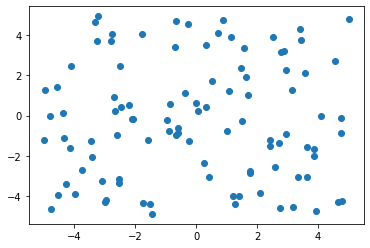

In [ ]:
x,y = np.random.uniform(-5,5,100), np.random.uniform(-5,5,100)
plt.scatter(x,y)



# Ok lets have a look at what we got!

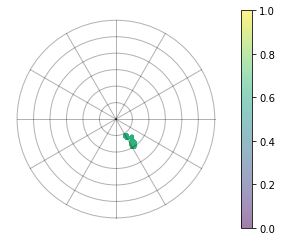

In [270]:
bprf.sampler[idx].visual_field(
    dot_col='rsq', dot_size=10, dot_vmin=0, dot_vmax=1, 
    th={'min-step_id':500}, # Not thresholding - lets show everything!
)

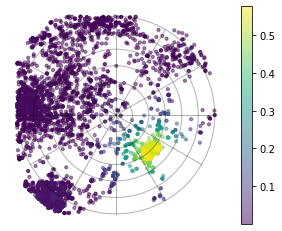

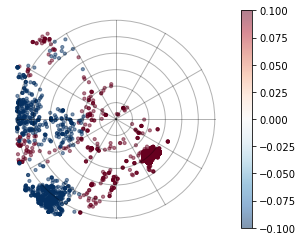

In [38]:
bprf2.sampler[91].visual_field(
    dot_col='rsq', 
    th={}, 
    dot_size=10, 
)
plt.figure()
bprf2.sampler[91].visual_field(
    dot_col='amp_1', 
    th={'min-step_id':500}, 
    dot_size=10, 
    dot_cmap='RdBu_r', dot_vmin=-.1, dot_vmax=.1,
)

In [10]:
bprf2.sampler[0].pd_params.amp_1.min()

-219349985.81756216

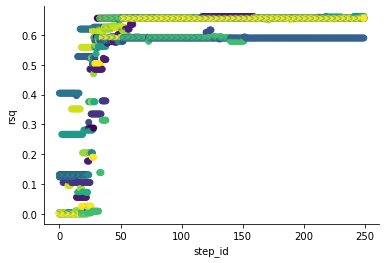

In [60]:
bprf2.sampler[0].scatter(
    'step_id', 'rsq', pc='walker_id', th={},
)

Ok hopefully that all ran! 

Lets look at what we got out!

In [8]:
# All the information for the fitting is stored in the object
# Lets have a look, does logprobability improve over time (it should!!)
bprf.sampler[0].scatter( # I have a bunch of functions for plotting useful PRF info
    px='step_id',  # Step number 
    py='logprob',  # Log probability
    pc='walker_id', # Lets color the points differently depending on start position
    th={},         # No need for thresholding, include everything!!
)
# Ok most things get better!


AttributeError: 'NoneType' object has no attribute 'scatter'

In [ ]:
# All the information for every microprobe is stored in the object
bprf.sampler[0].pd_params # This is a pandas dataframe with all the parameters

In [ ]:
# Lets look at the visual field coverage
bprf.sampler[0].visual_field( # Another one of my plotting functions!
    dot_col='rsq',  # Color the dots by the r squared value
    dot_size=10,   # Size of the dots
    th={},        # No thresholding
)

In [ ]:
# Lets look at the visual field coverage, but with some burn in
bprf.sampler[0].visual_field( # Another one of my plotting functions!
    dot_col='rsq',  # Color the dots by the r squared value
    dot_size=10,   # Size of the dots
    th={
        'min-step_id' : 100,  # Only include steps after 100
    },        # No thresholding
)